In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
from numpy import genfromtxt
import mystic.solvers as ms
import os

import generate_alphas as ga
import mom_constraint as mc
import extreme_data as extr
import damex_algo as dmx
import clef_algo as clf
import em_algo as em

In [3]:
# Airbus Data
x = genfromtxt('Data_Flights.csv', delimiter=',')
x = x[1:, 1:]
n, d_0 = np.shape(x)

# Each feature is doubled, separating points above and below the mean
mean = np.mean(x, axis=0)
var = x - mean
x_doubled = np.zeros((n, 2*d_0))
for j in range(d_0):
    x_doubled[var[:, j] > 0, j] = var[var[:, j] > 0, j]
    x_doubled[var[:, j] < 0, d_0 + j] = - var[var[:, j] < 0, j]

# Rank transformation, for each margin (column) V_i = n/(rank(X_i) + 1)
x_rank_0 = extr.rank_transformation(x_doubled)

# kth extremer points for the sum-norm
k_0 = int(2e3)
ind_extr_0 = np.argsort(np.sum(x_rank_0, axis=1))[::-1][:k_0]
x_extr_0 = x_rank_0[ind_extr_0]

# Sparse support
R_spars = np.min(np.max(x_extr_0, axis=1)) - 1
# Damex
eps_dmx = 0.5
mu_min = 0.001
alphas_0, mass = dmx.damex(x_extr_0, R_spars, eps_dmx, mu_min=mu_min)
alphas_dmx = clf.find_maximal_alphas(dmx.list_to_dict_size(alphas_0))
print(len(alphas_dmx))
print(alphas_dmx)
print([np.sum(np.sum(x_extr_0[:, alpha] > R_spars, axis=1) == len(alpha))
       for alpha in alphas_dmx])

# Extreme points; Only keeps features that appear in the alphas
alphas_0 = alphas_dmx
feats = list(set([j for alph in alphas_0 for j in alph]))
d = len(feats)
x_rank = x_rank_0[:, feats]
k_1 = int(500)
ind_extr = np.argsort(np.sum(x_rank, axis=1))[::-1][:k_1]
np.save('results/ind_extr.npy', ind_extr)
x_extr = x_rank[ind_extr]
np.save('results/extr_data.npy', x_extr)
alphas = ga.alphas_conversion(alphas_0)
np.save('results/alphas.npy', alphas)
mat_alphas = ga.alphas_matrix(alphas)
alphas_singlet = []
K = len(alphas)
K_tot = K + len(alphas_singlet)

31
[[163, 158], [157, 158], [163, 157], [75, 68, 76], [120, 121, 134], [24, 48, 27], [25, 145, 67, 92], [88, 89, 90, 91], [104, 25, 145, 67], [146, 147, 148, 86, 119], [114, 115, 116, 117, 118], [141, 142, 143, 144, 145], [18, 19, 20, 21, 22], [99, 133, 92, 151, 156], [96, 97, 98, 99, 95], [134, 135, 112, 113, 120], [12, 13, 14, 15, 16, 17], [162, 105, 108, 109, 110, 111], [38, 39, 52, 53, 30, 31], [161, 162, 8, 9, 84, 85], [107, 59, 60, 61, 62, 63], [100, 101, 102, 103, 104, 74], [0, 1, 2, 3, 77, 79], [128, 39, 107, 149, 87, 94, 127], [64, 65, 4, 37, 70, 71, 72, 73], [99, 133, 104, 74, 140, 118, 92, 126, 63], [40, 41, 42, 43, 44, 152, 153, 154, 155], [32, 33, 34, 35, 36, 54, 55, 56, 57, 58], [100, 101, 102, 103, 104, 54, 55, 56, 57, 58], [129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 94], [122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 136, 137, 138, 139, 140]]
[8, 6, 2, 3, 40, 10, 5, 8, 5, 45, 20, 11, 18, 7, 43, 23, 30, 3, 10, 10, 3, 0, 9, 2, 11, 1, 31, 13, 5, 11, 15]


In [4]:
x_extr = np.load('results/extr_data.npy')
n_extr, d = x_extr.shape
alphas = np.load('results/alphas.npy')
K = len(alphas)
K_tot = K
alphas_singlet = []

# Empirical rho
means_emp = [np.mean(em.project_on_simplex(x_extr, alpha), axis=0)
             for alpha in alphas]
weights_emp = np.ones(K)/K
rho_emp = mc.means_weights_to_rho(means_emp, weights_emp, alphas)

# Rho that verify moment constraint
rho_init = mc.project_rho(rho_emp, d)

# Init
nu_init = 20*np.ones(K)
theta_init = mc.rho_nu_to_theta(rho_init, nu_init, alphas)
lbda_init = 0.01*np.ones(K_tot)
noise_func = 'expon'
gamma_z_init = em.compute_gamma_z(x_extr, theta_init, lbda_init,
                                  alphas, alphas_singlet,
                                  noise_func)
Q_tot = em.Q_tot(theta_init, lbda_init, x_extr, gamma_z_init,
                 alphas, alphas_singlet,
                 noise_func)
cplt_lhood = em.complete_likelihood(x_extr, theta_init, lbda_init,
                                    alphas, alphas_singlet,
                                    noise_func)

# Constraints
theta_constraint = mc.Theta_constraint(alphas, d)

# Bounds
bds_r = [(0, 1./d) for i in range(len(theta_init[:-K]))]
bds_n = [(0, 100) for i in range(K)]
bds = bds_r + bds_n
n_loop = 20

# EM algorithm
gamma_z = np.copy(gamma_z_init)
lbda = np.copy(lbda_init)
theta = np.copy(theta_init)
gamma_z_list = [gamma_z]
lbda_list = [lbda]
theta_list = [theta]
check_list = [(-Q_tot, cplt_lhood)]
cpt = 0
crit_diff = 2.
while crit_diff > 1. and cpt < n_loop:
    # E-step
    gamma_z = em.compute_gamma_z(x_extr, theta, lbda,
                                 alphas, alphas_singlet,
                                 noise_func)
    gamma_z_list.append(gamma_z)
    # M-step
    # Minimize in lambda
    if noise_func == 'expon':
        lbda = em.compute_new_lambda(x_extr, gamma_z,
                                     alphas, alphas_singlet)
    if noise_func == 'pareto':
        lbda = em.compute_new_pareto(x_extr, gamma_z,
                                     alphas, alphas_singlet)
    lbda_list.append(lbda)
    # Minimize in theta
    theta = ms.diffev(em.Q, theta,
                      args=(x_extr, gamma_z, alphas),
                      bounds=bds,
                      constraints=theta_constraint)
    theta_list.append(theta)
    # New likelihood
    Q_tot_ = em.Q_tot(theta, lbda, x_extr, gamma_z,
                      alphas, alphas_singlet,
                      noise_func)
    cplt_lhood_ = em.complete_likelihood(x_extr, theta, lbda,
                                         alphas, alphas_singlet,
                                         noise_func)
    crit_diff = abs(Q_tot_ - Q_tot)
    Q_tot = Q_tot_
    cplt_lhood = cplt_lhood_
    print(-Q_tot, cplt_lhood)
    check_list.append((-Q_tot, cplt_lhood))
    cpt += 1
np.save('results/gamma_z_dmx.npy', gamma_z)

Optimization terminated successfully.
         Current function value: -3638.122287
         Iterations: 64
         Function evaluations: 2093
-355588.76961288345 -288811.49131738103
Optimization terminated successfully.
         Current function value: -3501.601634
         Iterations: 153
         Function evaluations: 6457
-341559.524434119 -274216.67721523374
Optimization terminated successfully.
         Current function value: -3521.362233
         Iterations: 395
         Function evaluations: 35994
-338090.8223119116 -268536.66425439634
Optimization terminated successfully.
         Current function value: -3462.428013
         Iterations: 78
         Function evaluations: 9082
-339110.132719794 -267509.57365175436
Optimization terminated successfully.
         Current function value: -3452.762821
         Iterations: 322
         Function evaluations: 36987
-339443.9719879781 -267833.9101973732
Optimization terminated successfully.
         Current function value: -3454.99474

### Visualization

/home/mael/miniconda3/envs/evt/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mael/miniconda3/envs/evt/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/mael/miniconda3/envs/evt/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


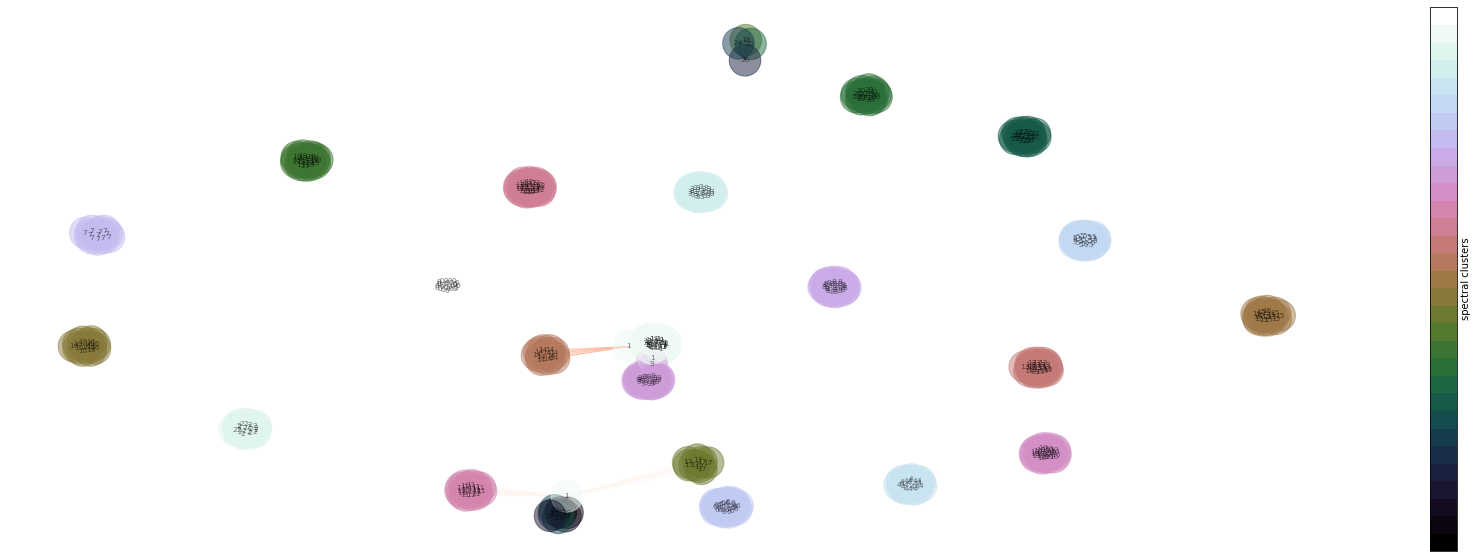

In [11]:
import matplotlib.pyplot as plt
import itertools as it
import networkx as nx
from sklearn.cluster import KMeans

def reconstruct_alphas(alphas, feats, d_0):
    alphas_0 = [[feats[j] for j in alpha] for alpha in alphas]
    alphas_1 = []
    for alpha in alphas_0:
        alpha_1 = []
        for j in alpha:
            if j > d_0-1:
                alpha_1.append(j - d_0)
            else:
                alpha_1.append(j)
        alphas_1.append(alpha_1)

    return alphas_1

# Adjacency Matrix
gamma_z = np.load('results/gamma_z_dmx.npy')
n_extr, K_tot = gamma_z.shape
gamma_z = gamma_z[np.max(gamma_z, axis=1) > 1./K_tot + 1e-8]
n_extr, K = np.shape(gamma_z)
W = np.zeros((n_extr, n_extr))
for (i, j) in it.combinations(range(n_extr), 2):
    W[i, j] = np.sum(gamma_z[i] * gamma_z[j])
    W[j, i] = W[i, j]

# Spectral clustering
K_spec = K
L = np.diag(np.sum(W, axis=1)) - W
eigval, eigvect = np.linalg.eigh(L)
kmeans = KMeans(n_clusters=K_spec).fit(eigvect[:, :K_spec])
labels = kmeans.labels_
ind_extr = np.load('results/ind_extr.npy')
flights_ind = np.nonzero(ind_extr)[0]

# Final clusters
alphas = np.load('results/alphas.npy')
x_extr = np.load('results/extr_data.npy')
# y_extr = np.load('results/extr_lab.npy')
# K_lab = len(set(y_extr))
K_lab = len(set(labels))
d = x_extr.shape[1]
feats = [j for alpha in alphas for j in alpha]
flights_parameters_clusters = reconstruct_alphas(alphas, feats, d)

# Networkx visualisation 0
G = nx.from_numpy_matrix(W)
W_min = np.mean(W)
W_thresh = W*(W > W_min)
G_edges = []
weights_edges = []
for edge in G.edges():
    if W_thresh[edge] > W_min:
        G_edges.append(edge)
        weights_edges.append(W_thresh[edge])
G_visu = nx.from_numpy_matrix(W_thresh)
labels_dict = {i: str(labels[i])
               for i in range(n_extr)}

fig, ax = plt.subplots(figsize=(30, 10))
cmap = plt.get_cmap('cubehelix', K_lab)
pos = nx.spring_layout(G_visu, k=0.05)
nx.draw(G_visu,
        pos=pos,
        edgelist=G_edges,
        node_size=1e3,
        node_color=(K_lab - np.array(labels))/float(K_lab),
        alpha=0.5,
        cmap=cmap,
        edge_color=np.array(weights_edges),
        edge_cmap=plt.get_cmap(name='Reds'),
        font_size=7.5,
        labels=labels_dict
       )
sm = plt.cm.ScalarMappable(cmap=cmap)
sm._A = []
plt.colorbar(sm, ticks=[-0.5, K_spec+0.5], label='spectral clusters', ax=ax)
plt.show()

In [ ]:
# # Networkx visualisation with agglomerated points
# W_clusters = np.zeros((K_spec, K_spec))
# for k_0 in range(K_spec-1):
#     for k_1 in range(k_0+1, K_spec):
#         inds_k_0 = np.nonzero(labels == k_0)[0]
#         inds_k_1 = np.nonzero(labels == k_1)[0]
#         W_clusters[k_0, k_1] = np.sum(W[inds_k_0, :][:, inds_k_1])
#         W_clusters[k_1, k_0] = W_clusters[k_0, k_1]
# G_clusters = nx.from_numpy_matrix(W_clusters)
# node_color = []
# for node in G_clusters.nodes():
#     inds = np.nonzero(labels == node)[0]
#     node_color.append(np.sum(W[inds, :][:, inds])/np.sum(inds))
# G_clust_edges = []
# w_edges = []
# for edge in G_clusters.edges():
#     if W_clusters[edge] > 0.:
#         G_clust_edges.append(edge)
#         w_edges.append(W_clusters[edge])
# node_size = [np.sum(labels == k) for k in range(K_spec)]
# cmap = plt.get_cmap(name='Blues')
# labels_dict = {k: str(node_size[k]) for k in range(K_spec)}

# pos = nx.spring_layout(G_clusters, k=.2)
# nx.draw(G_clusters,
#         pos=pos,
#         node_size=5e2*np.array(node_size),
#         node_color=node_color,
#         alpha=0.75,
#         cmap=cmap,
#         edge_color=np.array(w_edges),
#         width=5,
#         # width=np.array(w_edges),
#         edge_cmap=plt.get_cmap(name='Reds'),
#         font_size=15,
#         labels=labels_dict)
# sm = plt.cm.ScalarMappable(cmap=cmap)
# sm._A = []
# plt.colorbar(sm, ticks=[-0.5, 1.5], label='intern connectivity')
# plt.show()